[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lyeskhalil/mlbootcamp2022/blob/main/lab_3_2_autoencoders.ipynb)


# UofT FASE ML Bootcamp
#### Wednesday, June 15
#### Autoencoders - Lab 2, Day 3 
#### Teaching team: Elias Khalil, Alex Olson, Rahul Patel, and Jake Mosseri
##### Lab author: Alexander Olson, aolson@mie.utoronto.ca, edited by Jake Mosseri


Yesterday we looked at a few methods of dimensionality reduction - PCA and t-SNE. Today we are going to learn about a _deep_ model for dimensionality reduction: Autoencoders.

An autoencoder is a special type of neural network with an unusual task: for some input X, all it has to do is return that input X as accurately as possible. But there's a catch, of course! Between the input and the output, the number of nodes in each hidden layer actually gets progressively _smaller_. This means that in the first half of the network, the network must learn how to represent the input in ever more compact formats. The second half does this in reverse, taking the smallest representation of the input and expanding it back out into the full, original data.

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/ae.png?raw=1" alt="cross-val" width="500"/>

Autoencoders are much more powerful than PCA and t-SNE when it comes to learning compact representations of data, as we will see here. Let's first bring back PCA and give it an autoencoder's task: first, reduce the dimensionality of a dataset, and then recover the full dimensionality of the original input.

We will use MNIST again today, although through a slightly different mechanism to ease its compatibility with Pytorch. Run the code below to download the dataset:

In [1]:
!pip3 install torch torchvision torchaudio
!pip install matplotlib
!pip install numpy
!pip install scikit-learn

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import numpy as np
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Path parameters
MNIST_PATH = Path('./mnist/')
DOWNLOAD_MNIST = not MNIST_PATH.exists()

In [3]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Training data size:	 torch.Size([60000, 28, 28])
Testing data size:	 torch.Size([60000])


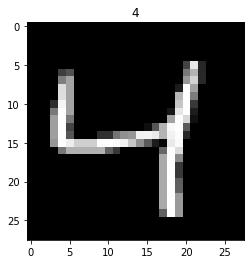

In [4]:
print('Training data size:\t',train_data.data.size())     # (60000, 28, 28)
print('Testing data size:\t',train_data.targets.size())   # (60000)
plt.imshow(train_data.data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[2])
plt.show()

**YOUR TURN**

Using PCA, reduce the dimensionality of the MNIST dataset to two dimensions. Then, using the `inverse_transform` method of the PCA object, transform the data back to its original size and plot the same data point shown above.

Note that to use the input data with the PCA library, you'll need to use Numpy's `reshape` command to convert a 60000x28x28 vector to 60000x784. Then on the other end, you'll need to convert back to 60000x28x28 in order to plot. For help with the `reshape` command, check [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html).

In [5]:
from sklearn.decomposition import PCA


* How does the image look after dimensionality reduction compared to the input? ______
* Why might it look this way? ______

Let's now move on to building an autoencoder for the same task. Autoencoders are easy networks to build, split into the _encoder_, which 'steps' the data down to the final compact representation, and the _decoder_, which is a mirror image of the encoder. 


In [6]:
myEncoder = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.Tanh(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, 12),
    nn.Tanh(),
    nn.Linear(12, 2),
)

As you may expect, designing the structure of the encoder is something of an art, and it requires balance between the time and input data required to train the network, and performance. Here we are using four step-down operations (the linear layers), which take us from the input of size 784 down to just two dimensions at the bottom. Between each step-down layer is a non-linear activation layer.

**Your turn**

It would of course be possible to go straight from the input size to the final number of dimensions, but we would lose an incredibly important aspect of neural networks in doing so.

* What would we miss out on? ______
* Why is this a problem? ______

In the cell below, build the structure of the decoder layer for our network. Remember, this is a mirror image of our encoder!

In [ ]:
myDecoder = nn.Sequential(
    ###Your code here
)

Finally, we just need some boilerplate class code to bring the whole thing together into a PyTorch network:

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = myEncoder
        self.decoder = myDecoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

Now let's create an instance of our network. We also need to define a few other parameters, like the loss function and the optimizer.

For the loss function, we will be using Mean Squared Error, which we covered in the second lab. For the optimizer, let's use an advanced optimizer called Adam:

In [8]:
autoencoder = AutoEncoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
loss_func = nn.MSELoss()

NameError: ignored

We'll use a helper function during training which will pass us the data as we go. It's important to remember that for an autoencoder, the input and the label are identical, so we don't have any labels per se.

In [9]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)

Our training function is going to show us the recovered images at the end of each epoch, to help us get an idea of how the training process is going. Beforehand, we will just plot out five of the digits so we can compare our autoencoder's output to what the target looks like:

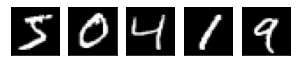

In [10]:
N_TEST_IMG = 5
# initialize figure
f, a = plt.subplots(1, N_TEST_IMG, figsize=(5, 2))
# original data (first row) for viewing
view_data = train_data.data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[i].set_xticks(()); a[i].set_yticks(())

OK, now we're ready to train! Before running this code, make sure you understand what is happening between the dashed lines (the rest is just there to draw the graphs, so it's not important). The comments should help. Once you feel comfortable, run the cell! It will take a little while to complete, but you will get progress updates as it goes.

In [12]:
for epoch in range(25):
    for step, (x, _) in enumerate(train_loader):
        #----------------------------------------------------------------------------#
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        #----------------------------------------------------------------------------#
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())
    f, a = plt.subplots(1, N_TEST_IMG, figsize=(5, 2))

    # plotting decoded image (second row)
    _, decoded_data = autoencoder(view_data)
    for i in range(N_TEST_IMG):
        a[i].clear()
        a[i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
        a[i].set_xticks(()); a[i].set_yticks(())
    plt.draw(); plt.pause(0.1)

NameError: ignored

The third image in the column is our Autoencoder's recovered version of the number 4 we looked at with PCA. How does it look? Could it be better?

We can also plot the encoded data in the same way we did for PCA and t-SNE in the last lab:

In [ ]:
plt.figure(figsize=(16,16))
view_data = train_data.data.view(-1, 28*28).type(torch.FloatTensor)/255.
encoded_data, _ = autoencoder(view_data)
X, Y = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy()
values = train_data.targets.numpy()

plt.figure(figsize=(16,10))
plt.scatter(X, Y,
            c=values, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();